# **Binary Prediction with a Rainfall Dataset**

## **Overview**

Welcome to the 2025 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

## **Problem definition**

### **Goal**

Your goal is to **predict rainfall** for each day of the year.

### **Evaluation**

Submissions are evaluated on [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) between the predicted probability and the observed target.

### **Submission File**

For each id in the test set, you must predict a probability for the target rainfall. The file should contain a header and have the following format:
```
id,rainfall
2190,0.5
2191,0.1
2192,0.9
etc.
```

### **Timeline**

- Start Date - March 1, 2025
- Entry Deadline - Same as the Final Submission Deadline
- Team Merger Deadline - Same as the Final Submission Deadline
- Final Submission Deadline - March 31, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

## **About the Tabular Playground Series**

The goal of the Tabular Playground Series is to provide the Kaggle community with a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The duration of each competition will generally only last a few weeks, and may have longer or shorter durations depending on the challenge. The challenges will generally use fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc.

### **Synthetically-Generated Datasets**

Using synthetic data for Playground competitions allows us to strike a balance between having real-world data (with named features) and ensuring test labels are not publicly available. This allows us to host competitions with more interesting datasets than in the past. While there are still challenges with synthetic data generation, the state-of-the-art is much better now than when we started the Tabular Playground Series two years ago, and that goal is to produce datasets that have far fewer artifacts. Please feel free to give us feedback on the datasets for the different competitions so that we can continue to improve!

### **Prizes**

- 1st Place - Choice of Kaggle merchandise
- 2nd Place - Choice of Kaggle merchandise
- 3rd Place - Choice of Kaggle merchandise

**Please note**: In order to encourage more participation from beginners, Kaggle merchandise will only be awarded once per person in this series. If a person has previously won, we'll skip to the next team.

### **Citation**

Walter Reade and Elizabeth Park. Binary Prediction with a Rainfall Dataset. https://kaggle.com/competitions/playground-series-s5e3, 2025. Kaggle.

## **Dataset Description**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Rainfall Prediction using Machine Learning](https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning) dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**Files**

- **train.csv** - the training dataset; rainfall is the binary target
- **test.csv** - the test dataset; your objective is to predict the probability of rainfall for each row
- **sample_submission.csv** - a sample submission file in the correct format.


## **Metadata**

#### **Licence**

[MIT](https://www.mit.edu/~amini/LICENSE.md)

# **Problem Solution**

## **Importing necessary libraries**

In [146]:
# Installing the xgboost library using the 'pip' command.
%pip install xgboost
%pip install xgboost
%pip install pandas
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# pandas
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

# Importing the XGBClassifier from the xgboost library
from xgboost import XGBClassifier
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

# Metrics to evaluate the model
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

## **Loading the dataset**

In [3]:
# For Colab
#from google.colab import drive
#drive.mount('/content/drive')
#data_directory="/content/drive/MyDrive/Shinhacker/data/"
#results_directory = "/content/drive/MyDrive/Shinhacker/working/"

In [4]:
#path='/kaggle/input/playground-series-s5e2/'
path_input ='./data'
path_output = './working'

In [5]:
# Define constants for attribute names.
columns = (
  'id', 'day', 'pressure', 'maxtemp', 'temperature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall'
)
# Upper case constants for variables.
for (v, w) in zip(map(str.upper, columns), columns):
    exec("%s = '%s'" % (v, w))

# Read in the data.
train_df = pd.read_csv(
    '/'.join([path_input,'train.csv']),                # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns,                                   # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns,                                 # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
test_df = pd.read_csv(
    '/'.join([path_input, 'test.csv']),                # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns[:-1],                              # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns[:-1],                            # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)

## **Checking the dataset**

In [6]:
train_df.shape, test_df.shape

((2190, 12), (730, 11))

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temperature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 222.4 KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2190 to 2919
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int64  
 1   pressure       730 non-null    float64
 2   maxtemp        730 non-null    float64
 3   temperature    730 non-null    float64
 4   mintemp        730 non-null    float64
 5   dewpoint       730 non-null    float64
 6   humidity       730 non-null    float64
 7   cloud          730 non-null    float64
 8   sunshine       730 non-null    float64
 9   winddirection  729 non-null    float64
 10  windspeed      730 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 68.4 KB


In [9]:
train_df.nunique(),test_df.nunique()

(day              365
 pressure         236
 maxtemp          219
 temperature      198
 mintemp          199
 dewpoint         218
 humidity          49
 cloud             78
 sunshine         120
 winddirection     35
 windspeed        223
 rainfall           2
 dtype: int64,
 day              365
 pressure         185
 maxtemp          182
 temperature      175
 mintemp          171
 dewpoint         172
 humidity          42
 cloud             69
 sunshine         110
 winddirection     29
 windspeed        205
 dtype: int64)

In [10]:
train_df.describe()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000,2190.000
mean,179.948,1013.602,26.366,23.953,22.170,20.455,82.037,75.722,3.744,104.863,21.805,0.753
std,105.204,5.655,5.654,5.222,5.059,5.288,7.801,18.026,3.626,80.002,9.899,0.431
min,1.000,999.000,10.400,7.400,4.000,-0.300,39.000,2.000,0.000,10.000,4.400,0.000
25%,89.000,1008.600,21.300,19.300,17.700,16.800,77.000,69.000,0.400,40.000,14.125,1.000
50%,178.500,1013.000,27.800,25.500,23.850,22.150,82.000,83.000,2.400,70.000,20.500,1.000
75%,270.000,1017.775,31.200,28.400,26.400,25.000,88.000,88.000,6.800,200.000,27.900,1.000
max,365.000,1034.600,36.000,31.500,29.800,26.700,98.000,100.000,12.100,300.000,59.500,1.000


In [11]:
test_df.describe()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,729.000,730.000
mean,183.000,1013.503,26.372,23.963,22.110,20.460,82.670,76.360,3.664,103.923,22.484
std,105.438,5.506,5.673,5.278,5.171,5.391,7.819,17.934,3.639,81.695,9.955
min,1.000,1000.000,7.400,5.900,4.200,-0.000,39.000,0.000,0.000,10.000,4.500
25%,92.000,1008.725,21.600,19.825,17.825,16.800,77.250,69.000,0.325,40.000,14.500
50%,183.000,1012.700,27.800,25.650,23.900,22.300,82.000,83.000,2.200,70.000,21.300
75%,274.000,1017.600,31.000,28.375,26.400,25.000,89.000,88.000,6.675,200.000,28.400
max,365.000,1032.200,35.800,31.800,29.100,26.700,98.000,100.000,11.800,300.000,59.500


### **Fix discontinous days**

In [12]:
# Fix discontinous days (use the fact that the indecies go from 0 with increment of 1).
train_df = train_df.assign(**{
    DAY: lambda x: np.array(x.index.to_list())%365+1
})
test_df = test_df.assign(**{
    DAY: lambda x: np.array(x.index.to_list())%365+1
})    

### **Interpolate missing winddirection data point**

In [13]:
# Interpolate missing winddirection data point (only single point so not fancy)
idx_fix = 2707
idx_show = idx_fix + np.array([-3,-2,-1,0,1,2,3])
display(test_df.loc[idx_show])
test_df.loc[idx_fix,WINDDIRECTION] = (100+220)/2//10*10
display(test_df.loc[idx_show])

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
id,,,,,,,,,,,
2704,150,1006.100,34.000,30.200,27.400,24.200,70.000,48.000,9.300,10.000,52.800
2705,151,1008.400,34.400,30.000,27.800,24.800,72.000,22.000,11.100,230.000,25.200
2706,152,1007.600,33.100,30.400,28.900,25.900,81.000,87.000,1.600,100.000,35.300
2707,153,1007.800,32.900,30.600,28.900,22.000,65.000,75.000,8.200,NaN,17.200
2708,154,1008.600,33.700,30.500,28.200,25.000,89.000,83.000,3.900,220.000,11.700
2709,155,1009.500,33.900,30.200,27.500,25.800,74.000,30.000,10.800,220.000,15.800
2710,156,1008.500,32.700,30.200,28.000,25.200,78.000,32.000,10.800,50.000,7.900


,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
id,,,,,,,,,,,
2704,150,1006.100,34.000,30.200,27.400,24.200,70.000,48.000,9.300,10.000,52.800
2705,151,1008.400,34.400,30.000,27.800,24.800,72.000,22.000,11.100,230.000,25.200
2706,152,1007.600,33.100,30.400,28.900,25.900,81.000,87.000,1.600,100.000,35.300
2707,153,1007.800,32.900,30.600,28.900,22.000,65.000,75.000,8.200,160.000,17.200
2708,154,1008.600,33.700,30.500,28.200,25.000,89.000,83.000,3.900,220.000,11.700
2709,155,1009.500,33.900,30.200,27.500,25.800,74.000,30.000,10.800,220.000,15.800
2710,156,1008.500,32.700,30.200,28.000,25.200,78.000,32.000,10.800,50.000,7.900


### **Making sure MINTEMP <= TEMERATURE <= MAXTEMP**

In [14]:
# First, if MAXTEMP < MINTEMP, then swap MAXTEMP and MINTEMP
itrn_max_min = train_df[MINTEMP] > train_df[MAXTEMP]
train_df.loc[itrn_max_min, MINTEMP], train_df.loc[itrn_max_min, MAXTEMP] = (train_df.loc[itrn_max_min, MAXTEMP], train_df.loc[itrn_max_min, MINTEMP])

In [15]:
itst_max_min = test_df[MINTEMP] > test_df[MAXTEMP]
test_df.loc[itst_max_min, MINTEMP], test_df.loc[itst_max_min, MAXTEMP] = (test_df.loc[itst_max_min, MAXTEMP], test_df.loc[itst_max_min, MINTEMP])

In [16]:
itrn_min_temp = train_df[MINTEMP] > train_df[TEMPERATURE]
itst_min_temp = test_df[MINTEMP] > test_df[TEMPERATURE]
train_df.loc[itrn_min_temp]

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
68,69,1015.000,17.800,16.000,16.900,16.600,90.000,51.000,9.500,60.000,24.900,0
675,311,1021.600,25.300,22.000,22.600,19.400,83.000,84.000,0.500,60.000,11.900,1
679,315,1016.400,21.900,18.600,18.800,15.400,76.000,88.000,8.600,70.000,26.800,1
802,73,1019.400,21.300,20.700,20.900,18.300,81.000,88.000,0.000,30.000,12.100,1
905,176,1005.400,31.100,28.400,28.800,25.500,84.000,86.000,6.800,220.000,16.700,1
1077,348,1017.900,20.600,18.800,19.100,17.800,85.000,91.000,0.300,40.000,13.000,1
1089,360,1019.500,17.700,16.000,16.500,16.500,93.000,97.000,0.000,50.000,21.400,1
1122,28,1024.600,16.100,13.000,13.500,11.900,76.000,89.000,0.000,200.000,33.200,0
1464,5,1027.100,10.800,7.400,8.100,2.500,61.000,95.000,0.100,20.000,24.000,1


In [17]:
itrn_max_temp = train_df[MAXTEMP] < train_df[TEMPERATURE]
itst_max_temp = test_df[MAXTEMP] < test_df[TEMPERATURE]
train_df.loc[itrn_max_temp]

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
1,2,1019.500,16.200,16.900,15.800,15.400,95.000,91.000,0.000,50.000,21.900,1
12,13,1020.400,15.000,15.500,13.200,12.000,77.000,86.000,0.000,50.000,32.400,1
319,320,1018.900,19.200,20.900,19.200,19.400,78.000,38.000,5.700,80.000,36.000,1
369,5,1022.400,12.100,13.800,11.200,2.700,75.000,68.000,6.000,70.000,27.600,0
398,34,1013.700,22.300,23.000,21.000,20.400,91.000,84.000,0.000,80.000,37.000,1
653,289,1016.600,26.200,26.800,23.200,20.400,79.000,69.000,5.000,40.000,22.400,1
702,338,1021.100,17.300,18.000,16.100,16.100,70.000,86.000,3.000,40.000,14.800,0
734,5,1024.400,11.300,11.400,10.400,8.600,77.000,88.000,0.000,20.000,39.300,1
796,67,1020.600,18.800,19.900,17.100,16.000,79.000,95.000,0.000,30.000,19.300,1


In [18]:
temp_dev_from_mean = pd.concat(
  [
    (
        train_df.loc[
          ((train_df[MINTEMP] < train_df[TEMPERATURE]) & (train_df[MAXTEMP] > train_df[TEMPERATURE])),
          TEMPERATURE
        ] - 
        train_df.loc[
          ((train_df[MINTEMP] < train_df[TEMPERATURE]) & (train_df[MAXTEMP] > train_df[TEMPERATURE])),
          MINTEMP
        ]
    ) / (
        train_df.loc[
          ((train_df[MINTEMP] < train_df[TEMPERATURE]) & (train_df[MAXTEMP] > train_df[TEMPERATURE])),
          MAXTEMP
        ] - 
        train_df.loc[
          ((train_df[MINTEMP] < train_df[TEMPERATURE]) & (train_df[MAXTEMP] > train_df[TEMPERATURE])),
          MINTEMP
        ]
    )
  ,
    (
        test_df.loc[
          ((test_df[MINTEMP] < test_df[TEMPERATURE]) & (test_df[MAXTEMP] > test_df[TEMPERATURE])),
          TEMPERATURE
        ] - 
        test_df.loc[
          ((test_df[MINTEMP] < test_df[TEMPERATURE]) & (test_df[MAXTEMP] > test_df[TEMPERATURE])),
          MINTEMP
        ]
    ) / (
        test_df.loc[
          ((test_df[MINTEMP] < test_df[TEMPERATURE]) & (test_df[MAXTEMP] > test_df[TEMPERATURE])),
          MAXTEMP
        ] - 
        test_df.loc[
          ((test_df[MINTEMP] < test_df[TEMPERATURE]) & (test_df[MAXTEMP] > test_df[TEMPERATURE])),
          MINTEMP
        ]
    )
  ]
).mean()
# Update the data
train_df.loc[itrn_max_temp, TEMPERATURE] = temp_dev_from_mean * (
    train_df.loc[itrn_max_temp, MAXTEMP] - train_df.loc[itrn_max_temp,MINTEMP]
) + (
    train_df.loc[itrn_max_temp, MINTEMP]
)
train_df.loc[itrn_min_temp, TEMPERATURE] = temp_dev_from_mean * (
    train_df.loc[itrn_min_temp, MAXTEMP] - train_df.loc[itrn_min_temp,MINTEMP]
) + (
    train_df.loc[itrn_min_temp, MINTEMP]
)
test_df.loc[itst_max_temp, TEMPERATURE] = temp_dev_from_mean * (
    test_df.loc[itst_max_temp, MAXTEMP] - test_df.loc[itst_max_temp,MINTEMP]
) + (
    test_df.loc[itst_max_temp, MINTEMP]
)
test_df.loc[itst_min_temp, TEMPERATURE] = temp_dev_from_mean * (
    test_df.loc[itst_min_temp, MAXTEMP] - test_df.loc[itst_min_temp,MINTEMP]
) + (
    test_df.loc[itst_min_temp, MINTEMP]
)

In [22]:
train_df.loc[itrn_min_temp]

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
68,69,1015.000,17.800,17.288,16.900,16.600,90.000,51.000,9.500,60.000,24.900,0
675,311,1021.600,25.300,23.764,22.600,19.400,83.000,84.000,0.500,60.000,11.900,1
679,315,1016.400,21.900,20.137,18.800,15.400,76.000,88.000,8.600,70.000,26.800,1
802,73,1019.400,21.300,21.072,20.900,18.300,81.000,88.000,0.000,30.000,12.100,1
905,176,1005.400,31.100,29.792,28.800,25.500,84.000,86.000,6.800,220.000,16.700,1
1077,348,1017.900,20.600,19.747,19.100,17.800,85.000,91.000,0.300,40.000,13.000,1
1089,360,1019.500,17.700,17.017,16.500,16.500,93.000,97.000,0.000,50.000,21.400,1
1122,28,1024.600,16.100,14.621,13.500,11.900,76.000,89.000,0.000,200.000,33.200,0
1464,5,1027.100,10.800,9.264,8.100,2.500,61.000,95.000,0.100,20.000,24.000,1


In [23]:
train_df.loc[itrn_max_temp]

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
1,2,1019.500,16.200,15.972,15.800,15.400,95.000,91.000,0.000,50.000,21.900,1
12,13,1020.400,15.000,13.976,13.200,12.000,77.000,86.000,0.000,50.000,32.400,1
319,320,1018.900,19.200,19.200,19.200,19.400,78.000,38.000,5.700,80.000,36.000,1
369,5,1022.400,12.100,11.588,11.200,2.700,75.000,68.000,6.000,70.000,27.600,0
398,34,1013.700,22.300,21.561,21.000,20.400,91.000,84.000,0.000,80.000,37.000,1
653,289,1016.600,26.200,24.494,23.200,20.400,79.000,69.000,5.000,40.000,22.400,1
702,338,1021.100,17.300,16.617,16.100,16.100,70.000,86.000,3.000,40.000,14.800,0
734,5,1024.400,11.300,10.788,10.400,8.600,77.000,88.000,0.000,20.000,39.300,1
796,67,1020.600,18.800,17.833,17.100,16.000,79.000,95.000,0.000,30.000,19.300,1


In [24]:
(train_df[MAXTEMP] < train_df[TEMPERATURE]).sum(),(train_df[MINTEMP] > train_df[TEMPERATURE]).sum(),(train_df[MAXTEMP] < train_df[MINTEMP]).sum(),

(0, 0, 0)

### **Theoretical Dew Point Tempearture**

In [88]:
# Dew Point Temperature ~ Temperature - (100 - Relative Humidity)/5
DEWCALC = 'dewcalc'
train_df = train_df.assign(**{
    DEWCALC: lambda x:  (x[TEMPERATURE] - (100.0 - x[HUMIDITY]) / 5.0) - x[DEWPOINT]
})
test_df = test_df.assign(**{
    DEWCALC: lambda x:  (x[TEMPERATURE] - (100.0 - x[HUMIDITY]) / 5.0) - x[DEWPOINT]
})

In [89]:
train_df.columns

Index(['day', 'pressure', 'maxtemp', 'temperature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall', 'dewcalc'],
      dtype='object')

## **EDA - Exploratory Data Analysis**

### **Plot Data**

In [90]:
# Continuous numeric travel data: AGE, TRAVEL_DIST, DEP_DELAY, ARR_DELAY
def plot_dist(traindata,testdata,w=15,h=10,nbins=30,title=None,xlabel=None,ylabel=None,show_Q=True):
    fig, (axs_trn_U, axs_tst_U, axs_trn_M, axs_tst_M, axs_trn_L, axs_tst_L) = plt.subplots(6, 1, figsize=(w,h))
    plt.subplots_adjust(hspace=0.25)
    axs_tst_U.sharex(axs_trn_U), axs_trn_M.sharex(axs_trn_U),axs_tst_M.sharex(axs_trn_U), axs_tst_L.sharex(axs_trn_L)
    skew = f"(train skew = {traindata.skew():#,.2g}".removesuffix(".") + f"; test skew = {testdata.skew():#,.2g}".removesuffix(".") + ")"
    # Add title
    if (title):
        fig.suptitle(f"{title} {skew}")
    else:
        fig.suptitle(f"Distribution of {traindata.name} {skew}")
    sns.histplot(x=traindata, ax=axs_trn_M, kde=True, bins=nbins)
    sns.histplot(x=testdata, ax=axs_tst_M, kde=True, bins=nbins)
    sns.boxplot(x=traindata, ax=axs_trn_U)   
    sns.boxplot(x=testdata, ax=axs_tst_U)   
    axs_trn_U.xaxis.set_tick_params(labelbottom=None), axs_trn_M.xaxis.set_tick_params(labelbottom=None), axs_trn_L.xaxis.set_tick_params(labelbottom=None)
    axs_trn_U.set_xlabel(''), axs_trn_M.set_xlabel('')
    axs_tst_U.xaxis.set_tick_params(labelbottom=None)
    axs_tst_U.set_xlabel(''), axs_tst_M.set_xlabel('')
    if show_Q:
        # Calculate mean and median and add them as labels.
        trn_q25, trn_median, trn_q75, trn_mean = (traindata.quantile(0.25), traindata.median(), traindata.quantile(0.75), traindata.mean())
        tst_q25, tst_median, tst_q75, tst_mean = (testdata.quantile(0.25), testdata.median(), testdata.quantile(0.75), testdata.mean())
        axs_trn_M.axvline(trn_q25, color='yellow', label=f"Q1 ({trn_q25:#,.3g}".removesuffix(".") + ")")
        axs_trn_M.axvline(trn_median, color='red', label=f"Median ({trn_median:#,.3g}".removesuffix(".") + ")")
        axs_trn_M.axvline(trn_mean, color='green', label=f"Mean ({trn_mean:#,.3g}".removesuffix(".") + ")")
        axs_trn_M.axvline(trn_q75, color='yellow', label=f"Q4 ({trn_q75:#,.3g}".removesuffix(".") + ")")
        axs_trn_M.legend(loc='upper left', fontsize='medium')
        axs_tst_M.axvline(tst_q25, color='yellow', label=f"Q1 ({tst_q25:#,.3g}".removesuffix(".") + ")")
        axs_tst_M.axvline(tst_median, color='red', label=f"Median ({tst_median:#,.3g}".removesuffix(".") + ")")
        axs_tst_M.axvline(tst_mean, color='green', label=f"Mean ({tst_mean:#,.3g}".removesuffix(".") + ")")
        axs_tst_M.axvline(tst_q75, color='yellow', label=f"Q4 ({tst_q75:#,.3g}".removesuffix(".") + ")")
        axs_tst_M.legend(loc='upper left', fontsize='medium')
    # Add labels on axes.
    if (xlabel): plt.xlabel(xlabel)
    if (ylabel): plt.ylabel(ylabel)
    sns.lineplot(ax=axs_trn_L,data=traindata)
    sns.lineplot(ax=axs_tst_L,data=testdata)
    plt.show()

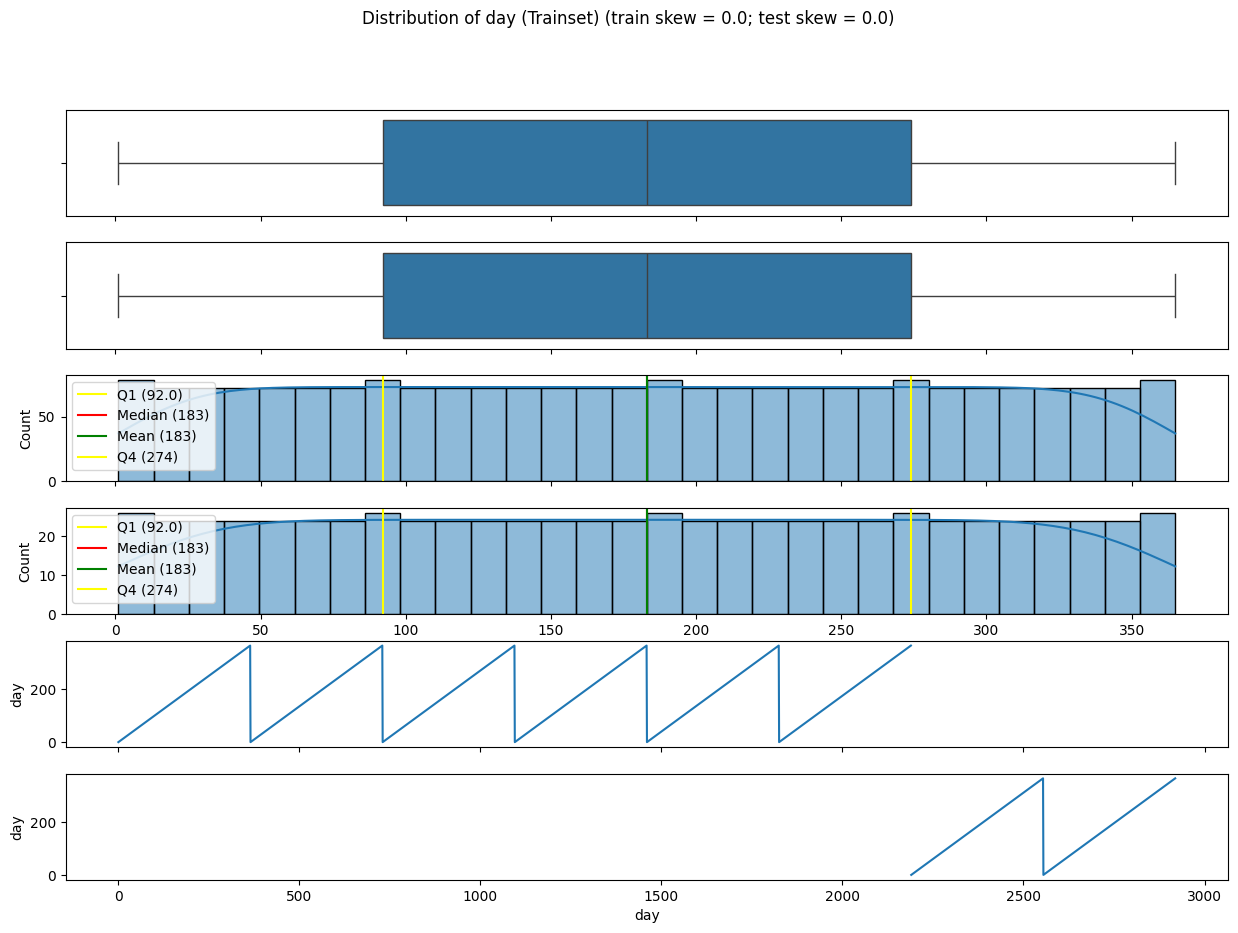

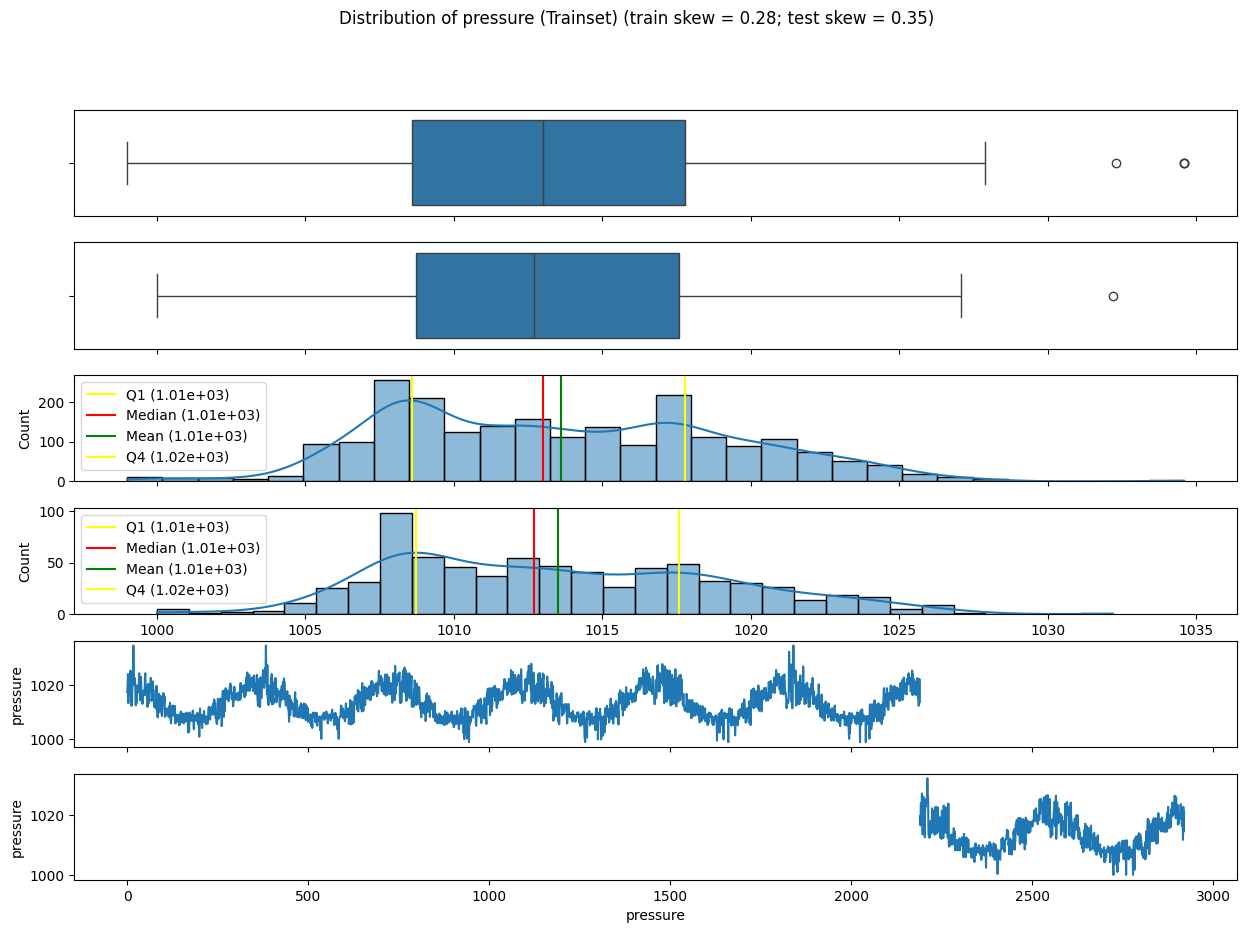

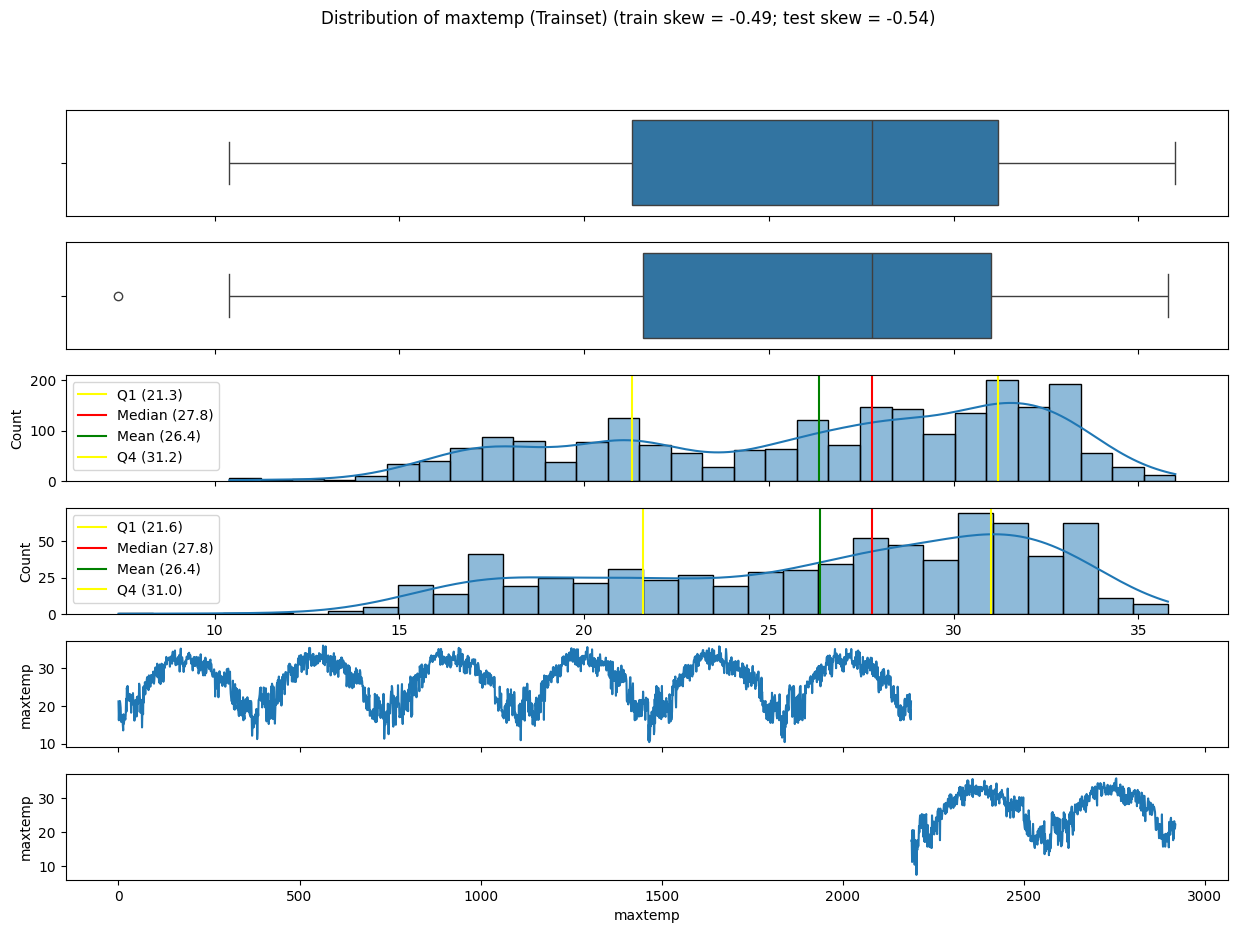

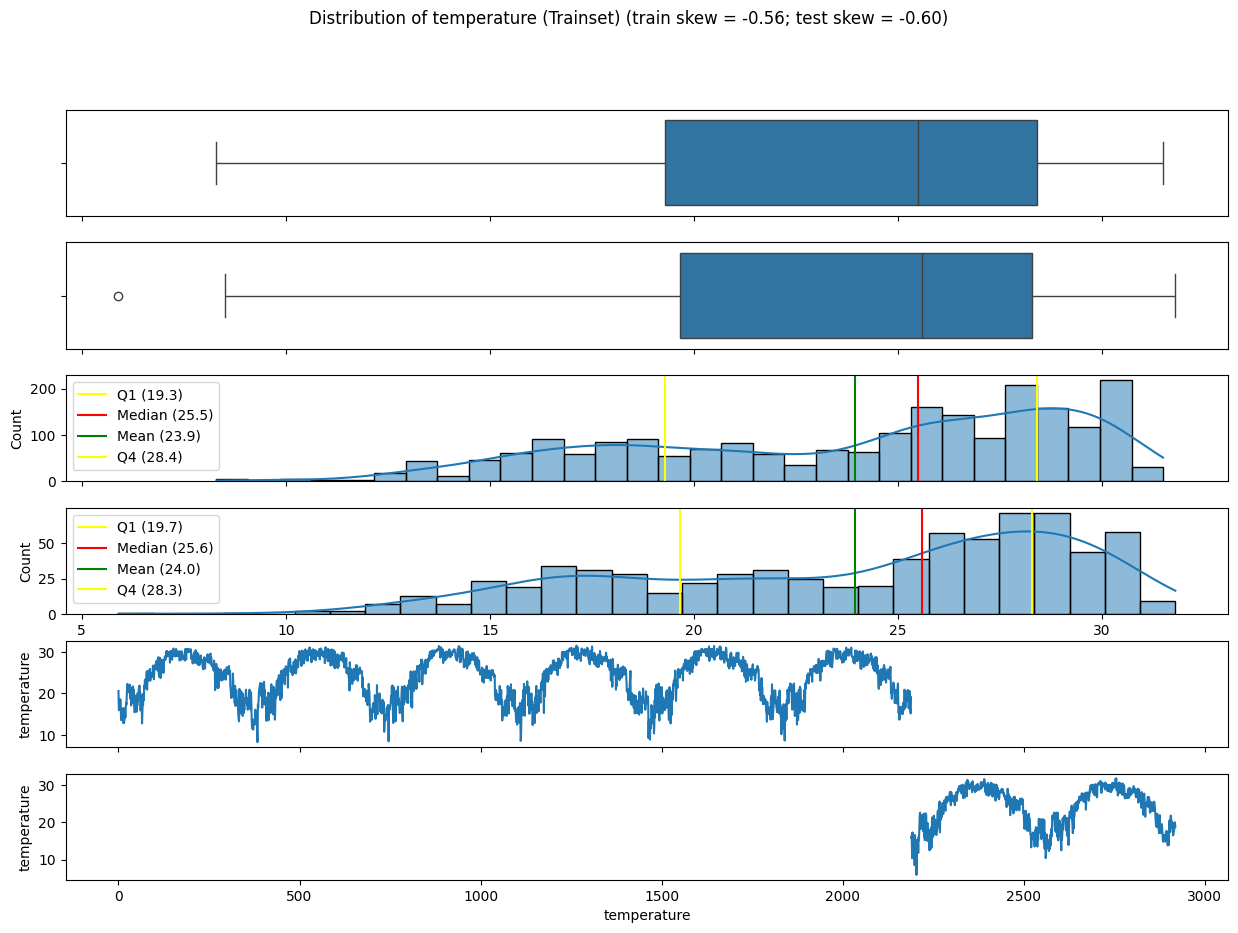

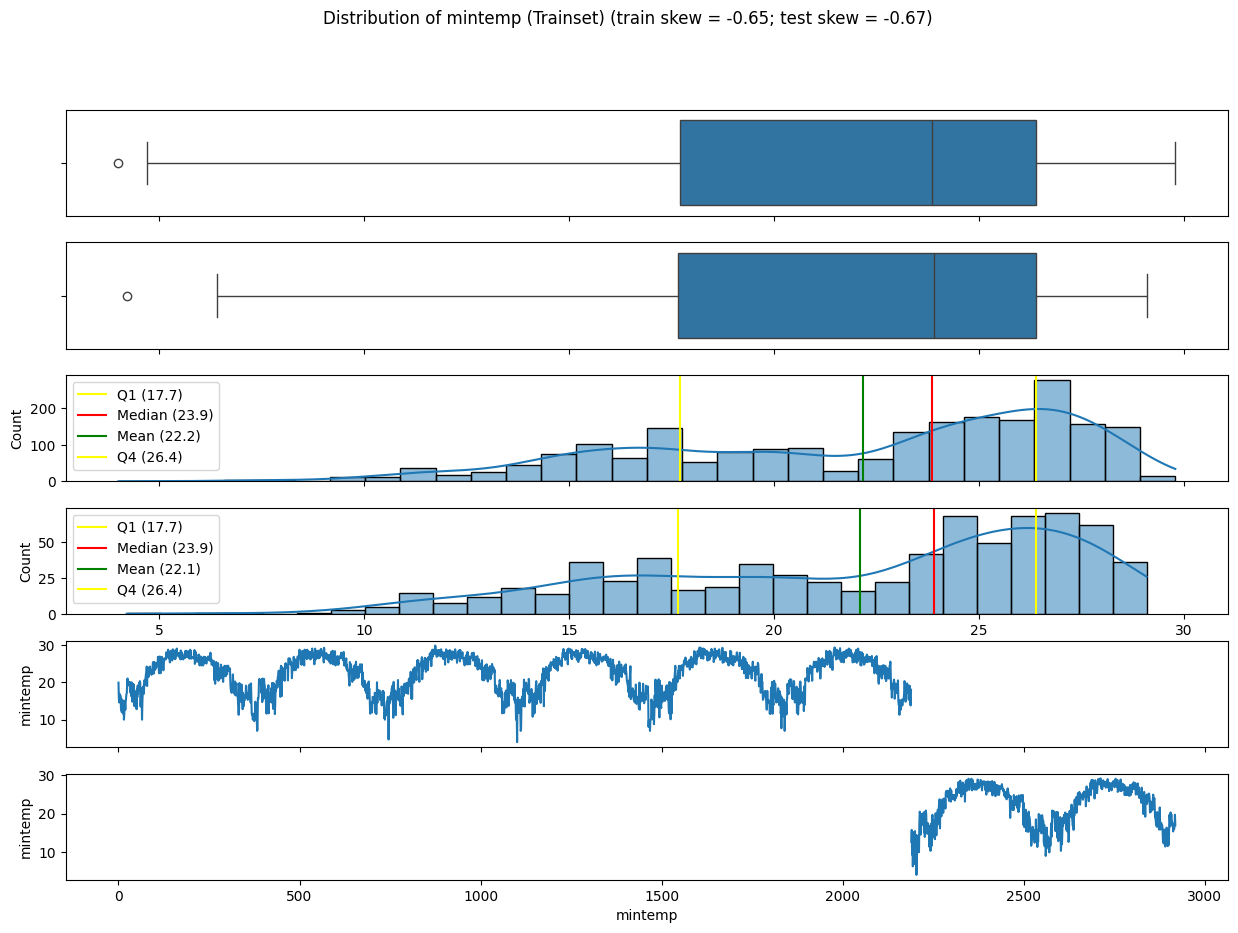

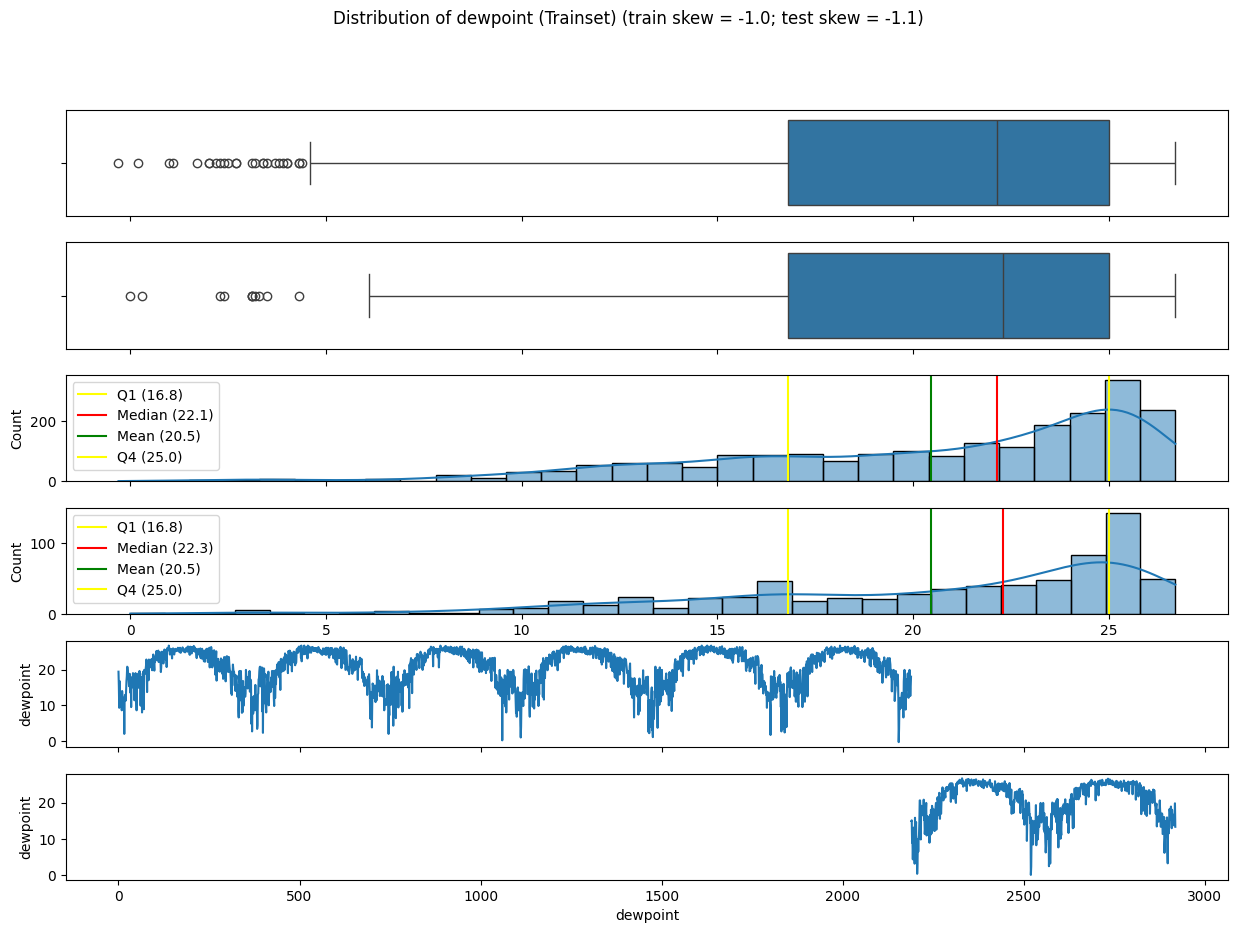

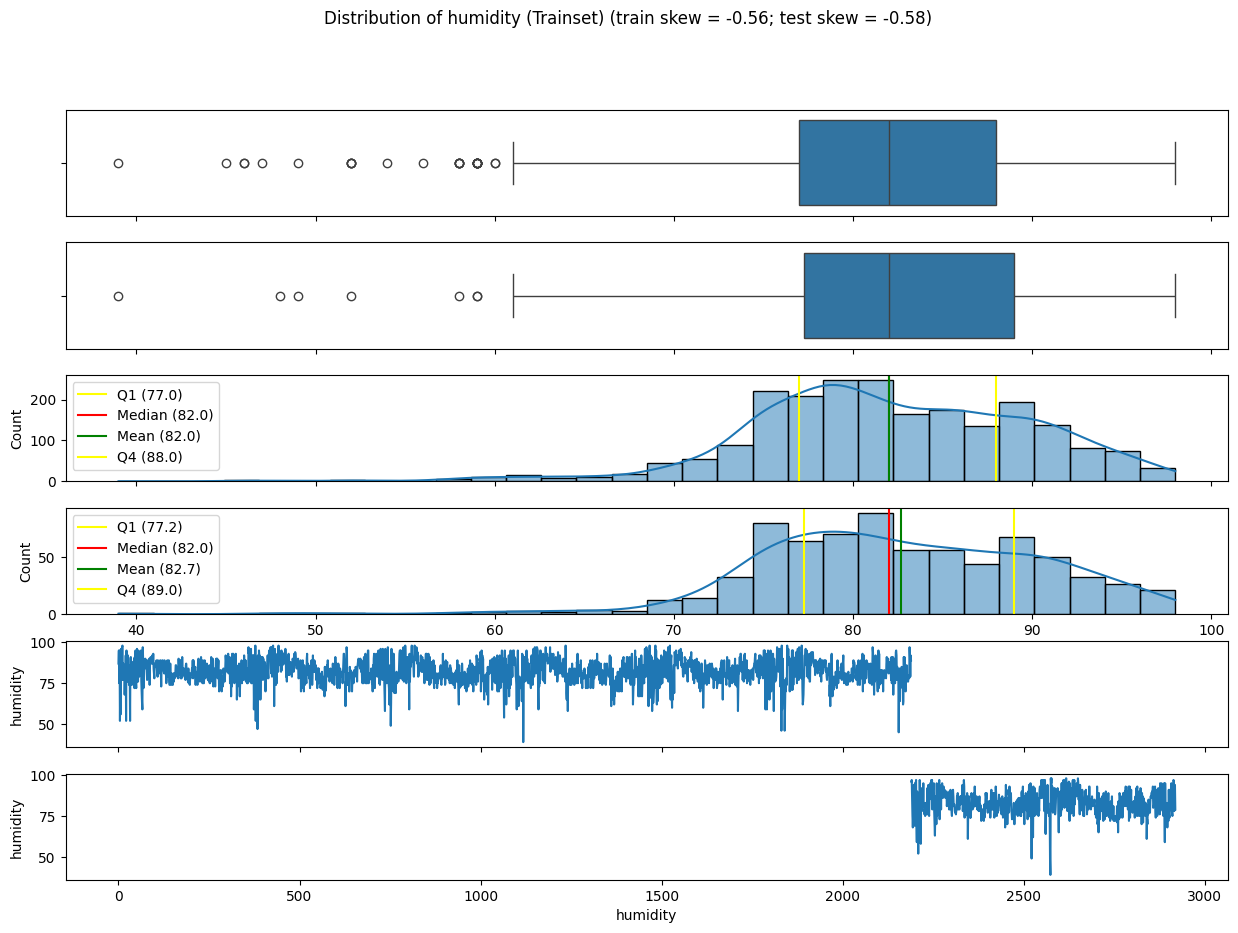

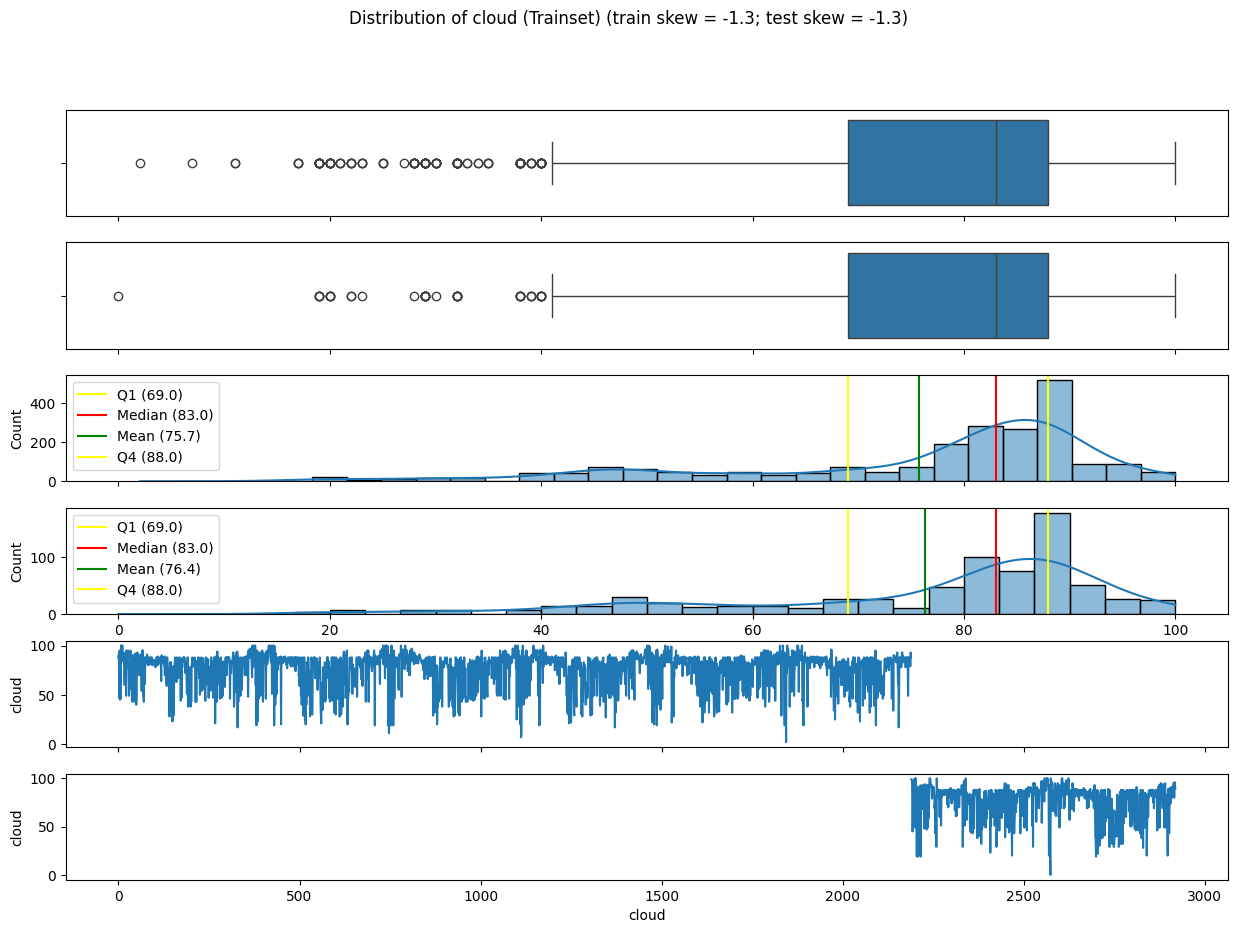

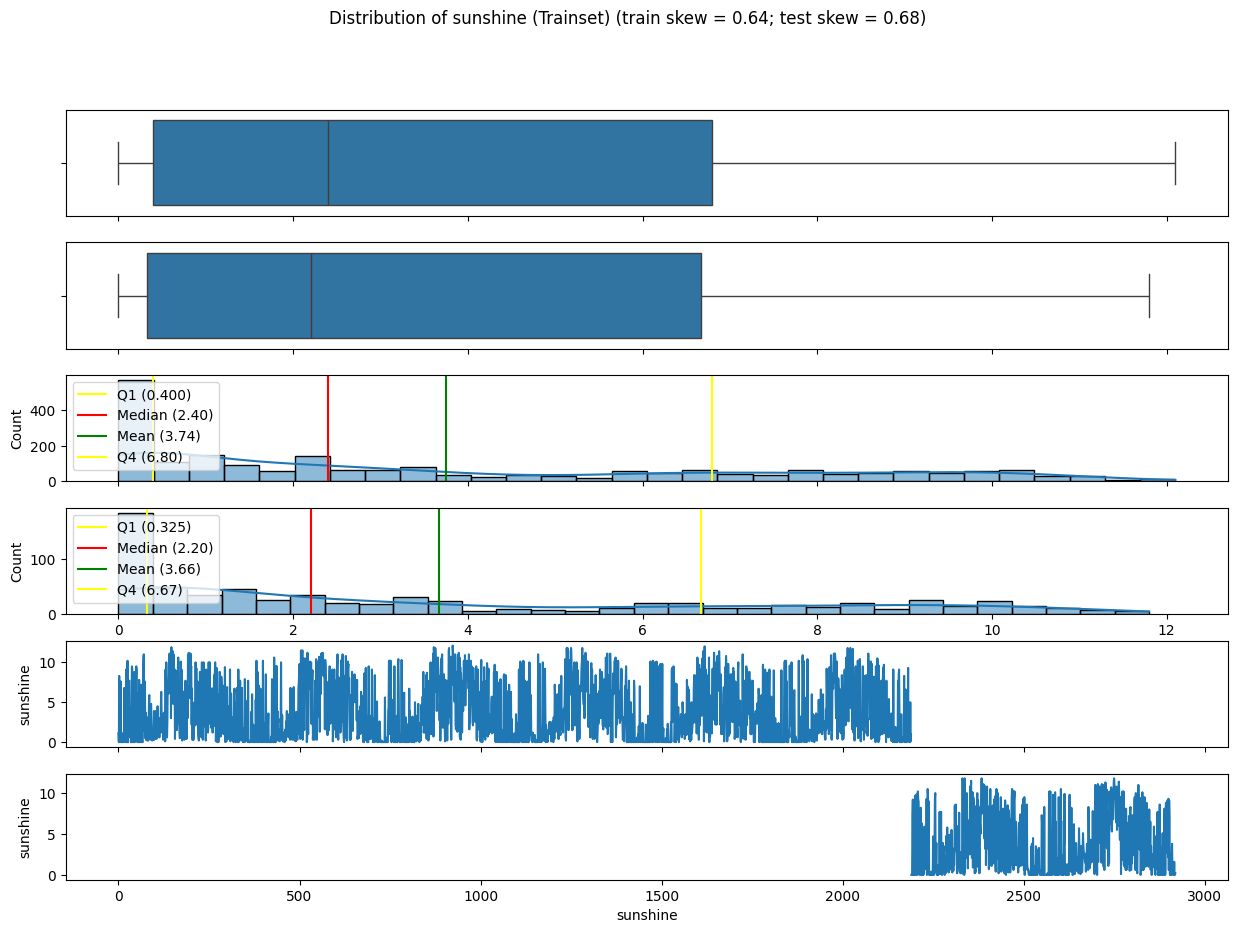

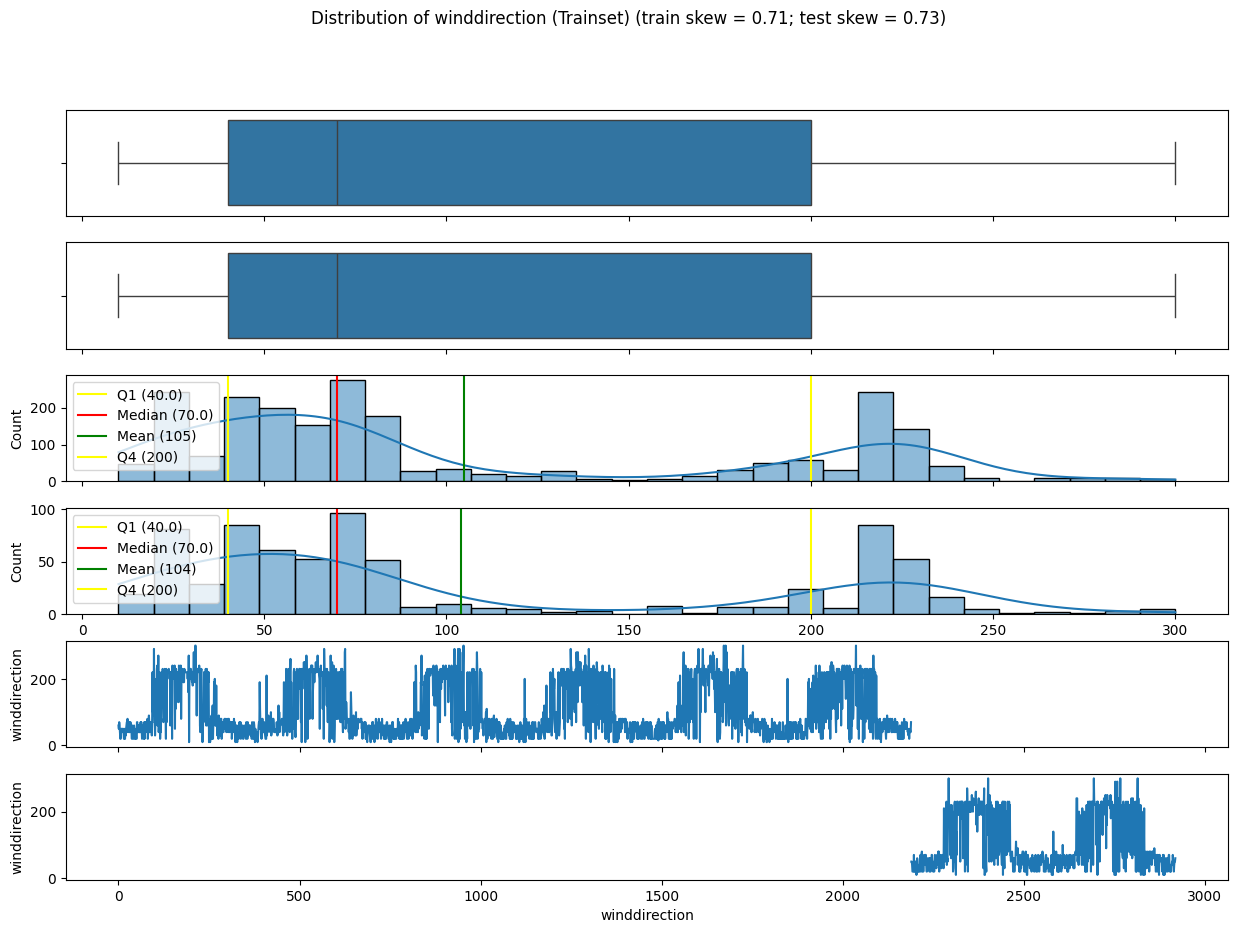

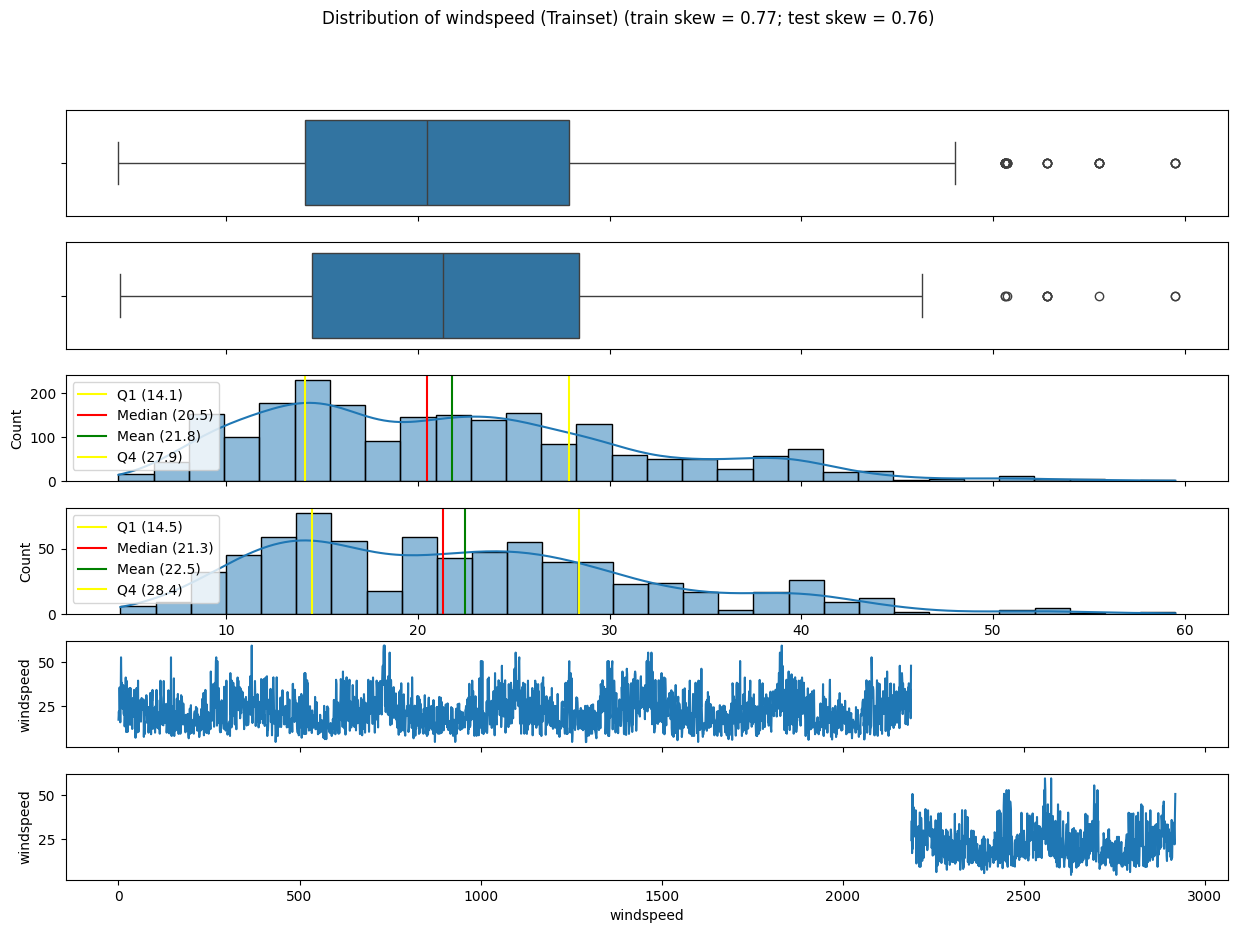

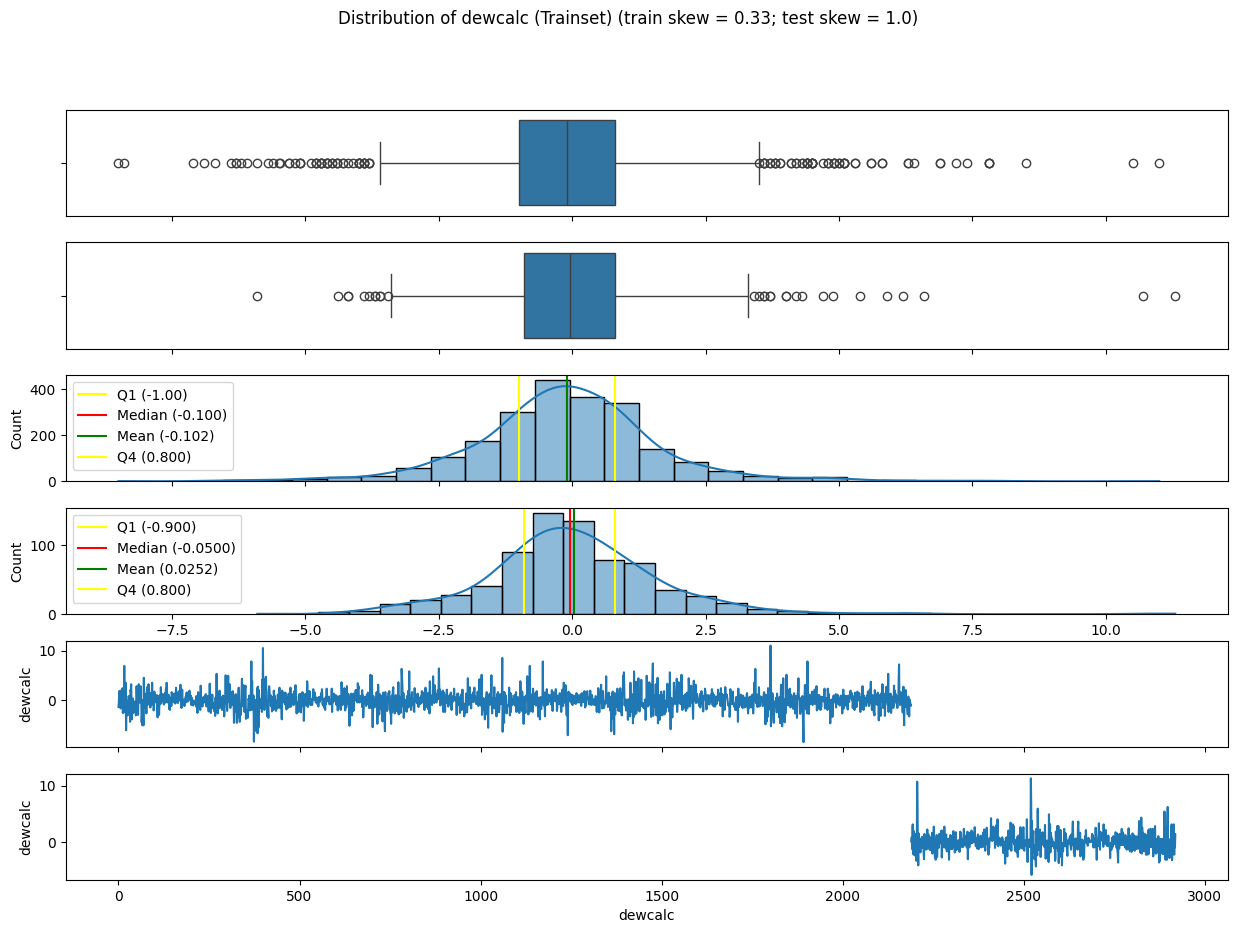

In [91]:
v = train_df.columns.to_list(); v.remove(RAINFALL)
for c in v:
    plot_dist(train_df[c], test_df[c], title=f"Distribution of {c} (Trainset)", xlabel=c)

### **Data Processing**

In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temperature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
 12  dewcalc        2190 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 239.5 KB


In [93]:
train_df.query(TEMPERATURE + '==' + MINTEMP)

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,dewcalc
id,,,,,,,,,,,,,
319,320,1018.900,19.200,19.200,19.200,19.400,78.000,38.000,5.700,80.000,36.000,1,-4.600
388,24,1015.000,21.600,20.400,20.400,17.400,95.000,88.000,0.500,70.000,20.800,1,2.000
1157,63,1015.500,19.900,18.100,18.100,17.100,96.000,92.000,0.200,40.000,14.100,1,0.200
1404,310,1014.200,21.300,20.500,20.500,19.900,91.000,88.000,0.000,70.000,46.300,1,-1.200
1429,335,1024.300,21.300,19.400,19.400,13.900,91.000,87.000,0.400,50.000,24.400,1,3.700
1430,336,1016.800,16.400,15.300,15.300,15.200,86.000,88.000,0.100,50.000,10.900,1,-2.700
1868,44,1020.500,15.200,14.600,14.600,12.500,90.000,80.000,0.000,50.000,39.500,1,0.100
1910,86,1020.300,27.500,24.400,24.400,20.400,76.000,77.000,1.500,50.000,13.000,1,-0.800
1999,175,1009.200,29.500,27.400,27.400,25.900,79.000,60.000,5.100,110.000,11.300,0,-2.700


In [94]:
train_df.query(TEMPERATURE + '==' + MAXTEMP)

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,dewcalc
id,,,,,,,,,,,,,
56,57,1012.000,20.900,20.900,19.100,14.900,86.000,80.000,1.600,60.000,13.800,0,3.200
319,320,1018.900,19.200,19.200,19.200,19.400,78.000,38.000,5.700,80.000,36.000,1,-4.600
726,362,1016.600,17.200,17.200,16.600,16.400,91.000,88.000,0.000,60.000,38.000,1,-1.000
1163,69,1017.800,20.100,20.100,19.600,19.800,92.000,83.000,0.300,50.000,16.100,1,-1.300
1418,324,1019.900,20.100,20.100,18.000,17.500,93.000,88.000,0.000,25.000,15.300,1,1.200
1466,7,1027.400,10.400,10.400,8.100,2.200,77.000,92.000,0.000,60.000,39.500,1,3.600
1828,4,1032.300,17.300,17.300,16.700,16.600,73.000,83.000,0.000,30.000,19.300,1,-4.700
1911,87,1012.900,25.900,25.900,24.400,23.300,91.000,88.000,1.500,90.000,31.800,1,0.800


In [95]:
rainfall_1 = train_df.query(RAINFALL + ' == 1')
rainfall_0 = train_df.query(RAINFALL + ' == 0')

In [96]:
rainfall_1.describe()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,dewcalc
count,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000
mean,183.012,1013.441,26.109,23.796,22.092,20.702,84.063,82.333,2.593,104.546,22.437,1.000,-0.094
std,106.560,5.384,5.529,5.071,4.888,4.952,6.911,11.113,2.886,78.449,9.824,0.000,1.643
min,1.000,999.000,10.400,8.900,4.000,0.200,58.000,20.000,0.000,10.000,4.500,1.000,-8.400
25%,92.000,1008.725,21.300,19.311,17.900,16.900,79.000,80.000,0.200,40.000,14.600,1.000,-1.000
50%,178.000,1013.000,27.600,25.400,23.700,22.250,84.000,85.000,1.500,70.000,21.600,1.000,-0.100
75%,279.000,1017.500,30.900,28.100,26.300,25.000,89.000,88.000,3.900,190.000,28.400,1.000,0.800
max,365.000,1034.600,36.000,31.300,29.300,26.700,98.000,100.000,11.800,300.000,59.500,1.000,11.000


In [97]:
rainfall_0.describe()

,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,dewcalc
count,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000
mean,182.963,1014.095,27.149,24.402,22.407,19.697,75.844,55.522,7.264,105.833,19.874,0.000,-0.126
std,101.829,6.395,5.959,5.674,5.548,6.148,7.073,19.982,3.384,84.640,9.886,0.000,2.139
min,4.000,999.000,10.400,8.300,4.700,-0.300,39.000,2.000,0.000,10.000,4.400,0.000,-8.500
25%,88.750,1008.500,21.600,19.225,17.550,15.450,73.000,43.000,4.975,40.000,12.300,0.000,-1.200
50%,194.000,1013.150,28.900,26.200,24.500,21.650,76.000,53.000,8.450,70.000,16.900,0.000,-0.100
75%,265.000,1019.425,32.400,29.625,27.000,24.800,79.000,72.000,10.000,210.000,25.100,0.000,0.800
max,358.000,1034.600,35.800,31.500,29.800,26.400,94.000,100.000,12.100,300.000,59.500,0.000,10.500


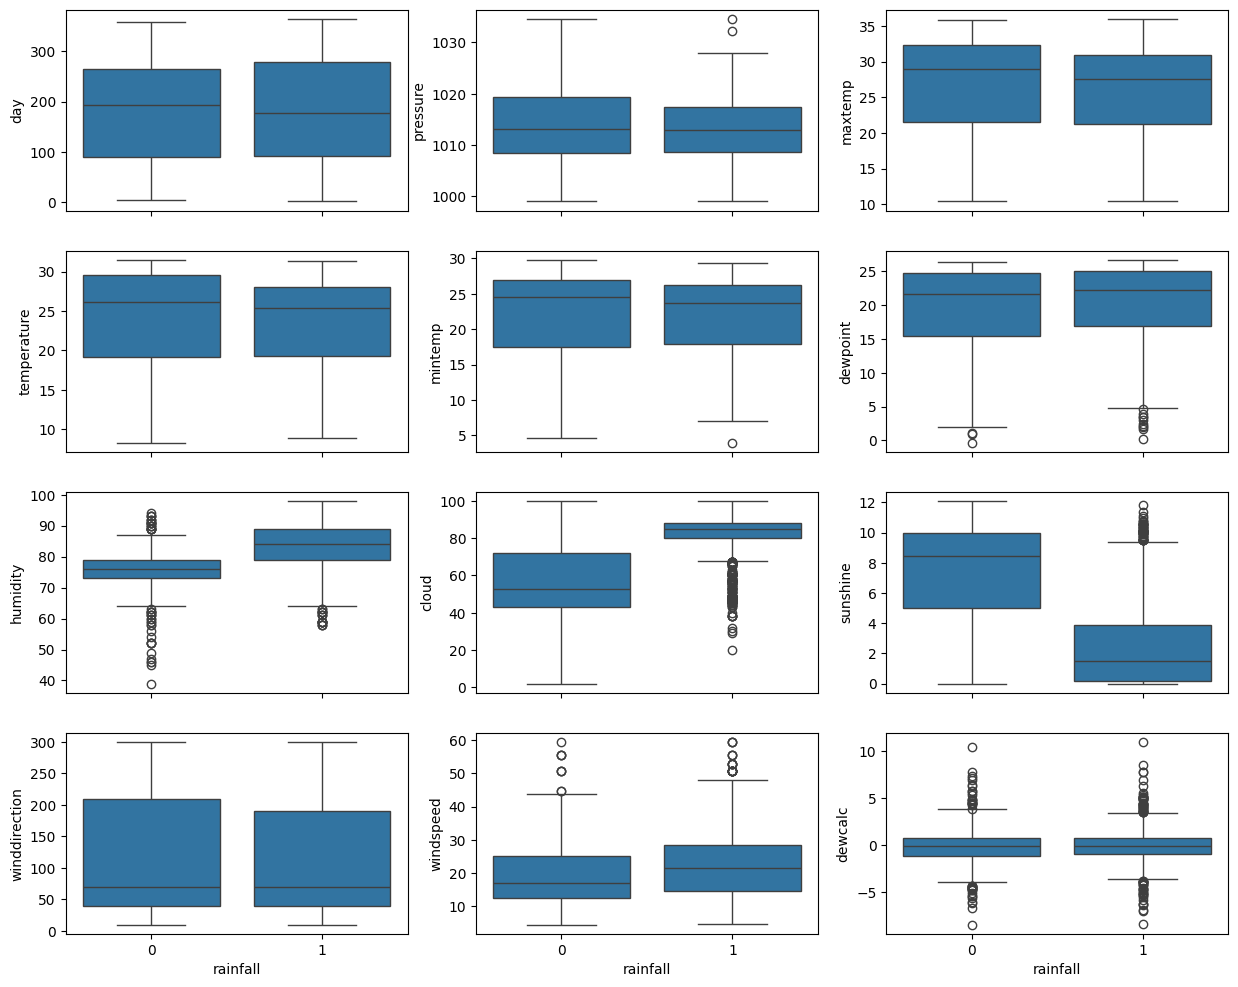

In [98]:
v = train_df.columns.to_list(); v.remove(RAINFALL)
fig, ax = plt.subplots((len(v)+1)//3, 3, sharex=True, figsize=(3*5,(len(v)+1)//3*3))
for i, c in enumerate(v):
  sns.boxplot(train_df, x=RAINFALL, y=c, ax=ax[i//3,i%3])
plt.show()

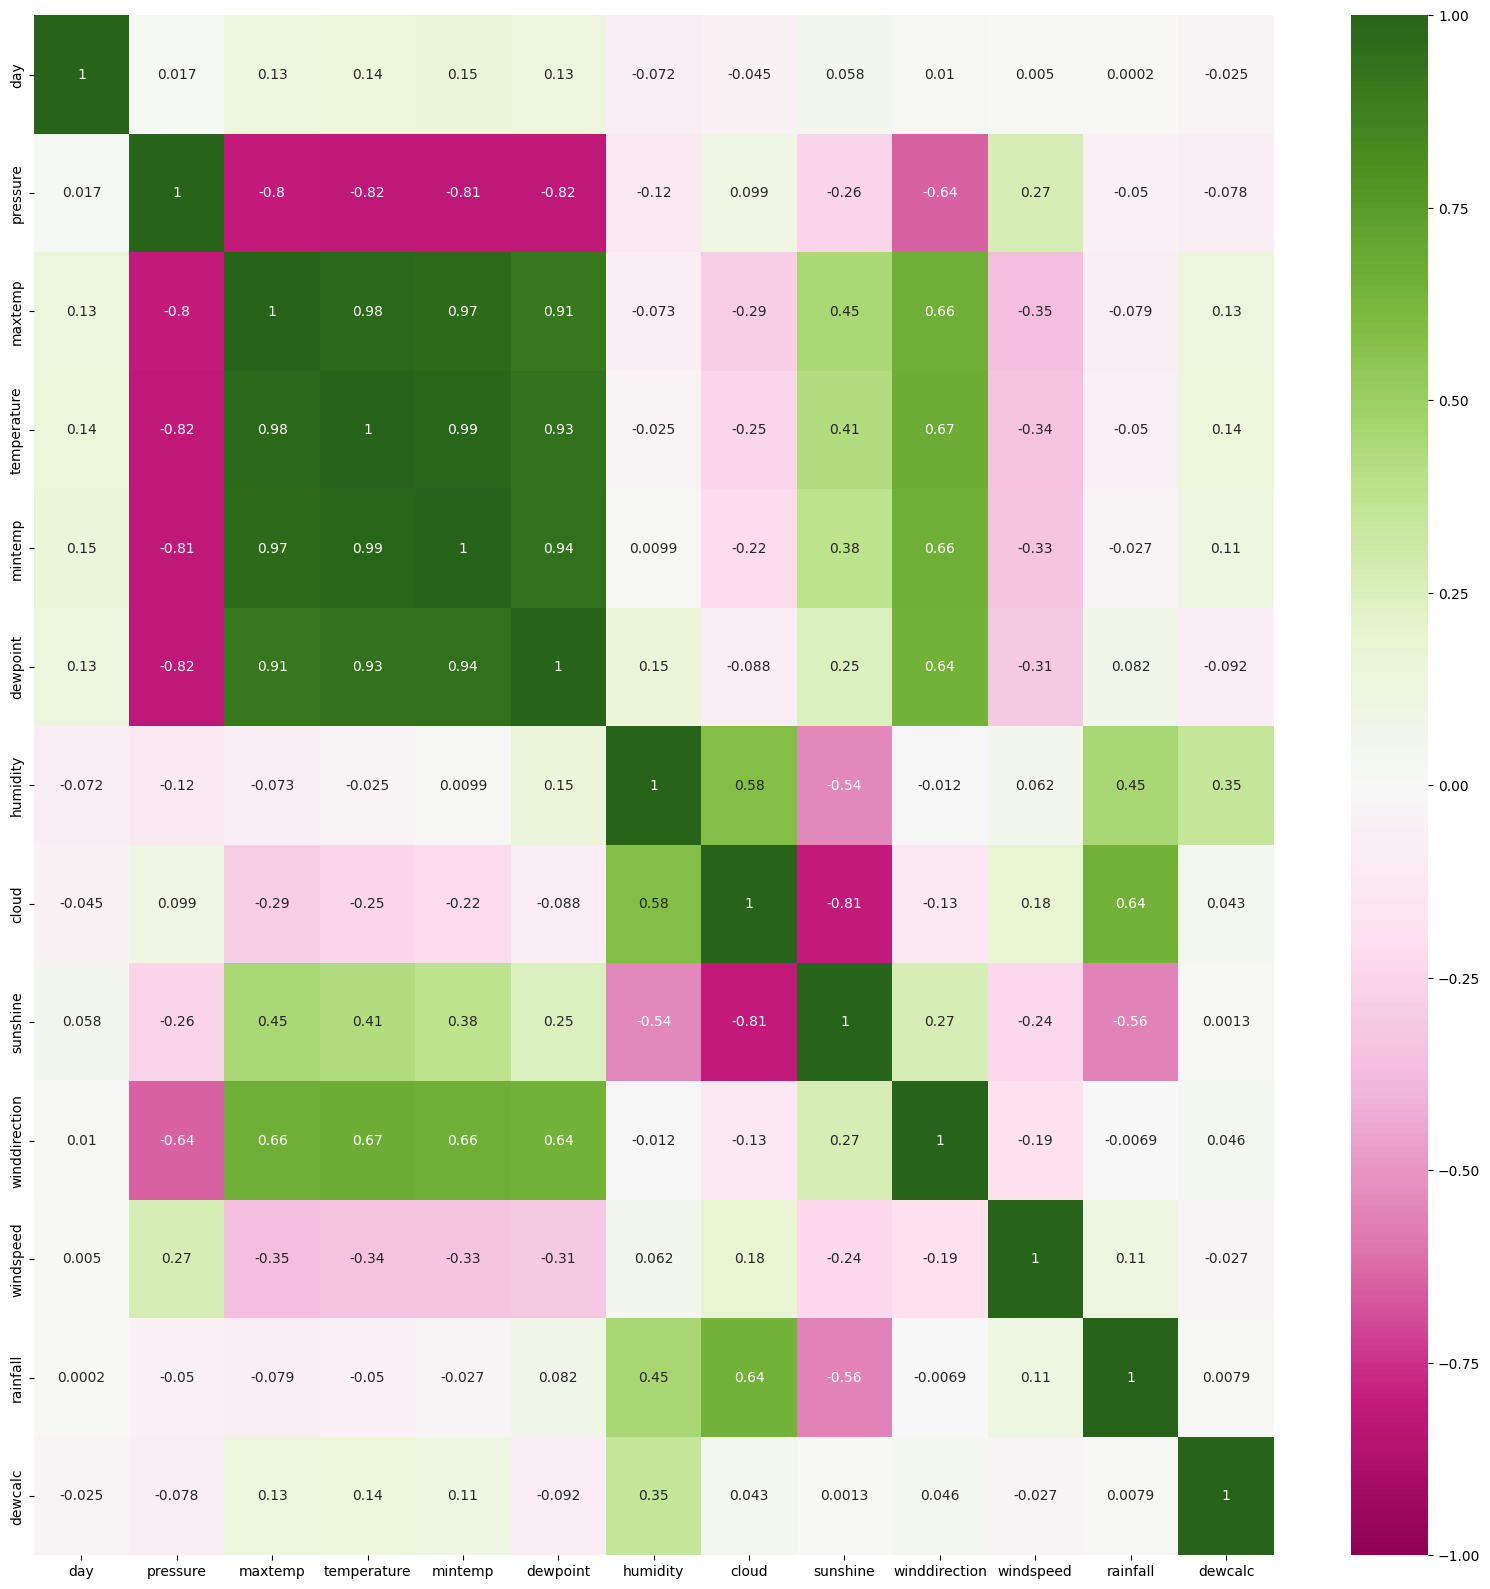

In [99]:
plt.figure(figsize  = (20, 20))

num_cols = train_df.select_dtypes(include = "number").columns.to_list()

sns.heatmap(train_df[num_cols].corr(), annot = True, vmin=-1, vmax=1, cmap = "PiYG")

plt.show()

## **Model Evaluation**

In [404]:
# Creating metric function

def metrics_score(actual, predicted, target_column=None):

    print(classification_report(actual, predicted, digits=6))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    # Lets use labels that make sense (if target_column supplied)
    nan_lb = 'NaN'
    n = cm.shape[0]
    if target_column:
        match target_column:
            case RAINFALL:
                axlb = ['Dry', 'Rain']
    else:
        axlb = [''] * n
    if n == 3: axlb = [nan_lb, *axlb] if target_column else [nan_lb, *axlb[1:]]

    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = axlb, yticklabels = axlb)

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()
    return classification_report(actual, predicted, digits=6, output_dict=True)['accuracy']

In [405]:
def model_performance_classification(model, predictors, target, ret_df=True):
    """
    Function to compute different metrics to check classification model performance

    model: classifier

    predictors: independent variables

    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall

    precision = precision_score(target, pred, average = 'macro')              # To compute precision

    acc = accuracy_score(target, pred)                                 # To compute accuracy score

    dict_perf = {"Precision": precision, "Recall": recall, "Accuracy": acc}

    if ret_df:
        # Creating a dataframe of metrics
        return pd.DataFrame(dict_perf, index = [0])

    # Creating a dictionary of metrics
    return dict_perf

In [406]:
def xgb_scores(estimator, X_train, X_test, y_train, y_test):
    train_score = estimator.score(X_train, y_train)
    sc_df_train = model_performance_classification(estimator,X_train, y_train, ret_df=False)

    test_score = estimator.score(X_test, y_test)
    sc_df_test = model_performance_classification(estimator,X_test, y_test, ret_df=False)

    print(f"""Model metrics:
    TRAIN ({(train_score+sum(sc_df_train.values()))/4.0:.3f}):\
    Score = {train_score:.3f}, Precision = {sc_df_train['Precision']:.3f}, Recall = {sc_df_train['Recall']:.3f}, Accuracy = {sc_df_train['Accuracy']:.3f}
    TEST  ({(test_score+sum(sc_df_test.values()))/4.0:.3f}):\
    Score = {test_score:.3f}, Precision = {sc_df_test['Precision']:.3f}, Recall = {sc_df_test['Recall']:.3f}, Accuracy = {sc_df_test['Accuracy']:.3f}
    """)

    return train_score, test_score, sc_df_train, sc_df_test

def simple_XGB_optimation(xgb,X,y,cv):
    Xv = X if isinstance(X, np.ndarray) else X.values
    yv = y if isinstance(y, np.ndarray) else y.values
    results = {}
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train = Xv[train]
        X_test = Xv[test]
        y_train = yv[train]
        y_test = yv[test]
        est = clone(xgb)
        est.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        train_score, test_score, m_train_sc, m_test_sc = xgb_scores(
            est, X_train, X_test, y_train, y_test
        )
        results[i] = (est, train_score, test_score, m_train_sc, m_test_sc)
    # Choose the model with the best score (as the sum of all metrics)
    m = max(results.values(),key=lambda v: v[1]+v[2]+sum(v[3].values())+sum(v[4].values()))
    trs, tss, tr_m, ts_m = m[1:]
    print(f"""Metrics for best XGBoost model:
    TRAIN ({(trs+sum(tr_m.values()))/4.0:.3f}):  Score = {trs:.3f}, Precision = {tr_m['Precision']:.3f}, Recall = {tr_m['Recall']:.3f}, Accuracy = {tr_m['Accuracy']:.3f}
    TEST  ({(tss+sum(ts_m.values()))/4.0:.3f}):  Score = {tss:.3f}, Precision = {ts_m['Precision']:.3f}, Recall = {ts_m['Recall']:.3f}, Accuracy = {ts_m['Accuracy']:.3f}
    """)
    return m[0]

### **Splitting the dataset**

In [407]:
final_df = train_df.copy()

In [408]:
# Create train and test datasets
pcnt = .7
target_column = RAINFALL

# Random state is a seed value
train = final_df.sample(frac = pcnt, random_state = 14)
test = final_df.drop(train.index)

columns = final_df.columns.to_list()
columns.remove(target_column)

x_train = train[columns]
x_test = test[columns]

y_train = train[target_column]
y_test = test[target_column]

np.random.seed(0)

### **Random Forest**

In [409]:
rf = RandomForestClassifier(random_state = 1, criterion = 'entropy', class_weight = 'balanced')
rf = rf.fit(x_train, y_train)

              precision    recall  f1-score   support

           0   0.748252  0.656442  0.699346       163
           1   0.891051  0.927126  0.908730       494

    accuracy                       0.859970       657
   macro avg   0.819651  0.791784  0.804038       657
weighted avg   0.855623  0.859970  0.856783       657



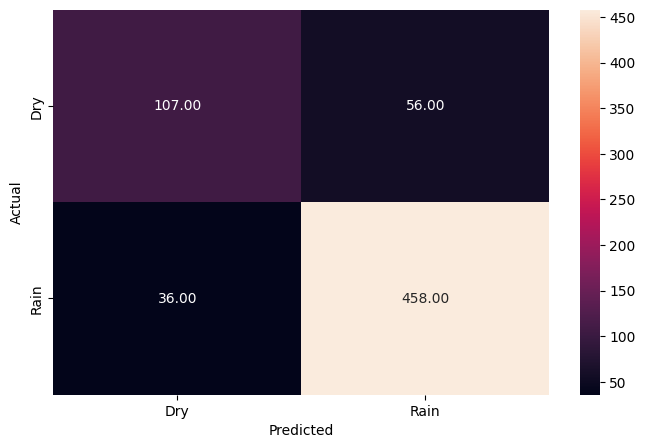

In [410]:
# Checking performance on the test data
y_pred_test_rf_tuned = rf.predict(x_test)

test_rf_acc = metrics_score(y_test, y_pred_test_rf_tuned, target_column)

              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000       377
           1   1.000000  1.000000  1.000000      1156

    accuracy                       1.000000      1533
   macro avg   1.000000  1.000000  1.000000      1533
weighted avg   1.000000  1.000000  1.000000      1533



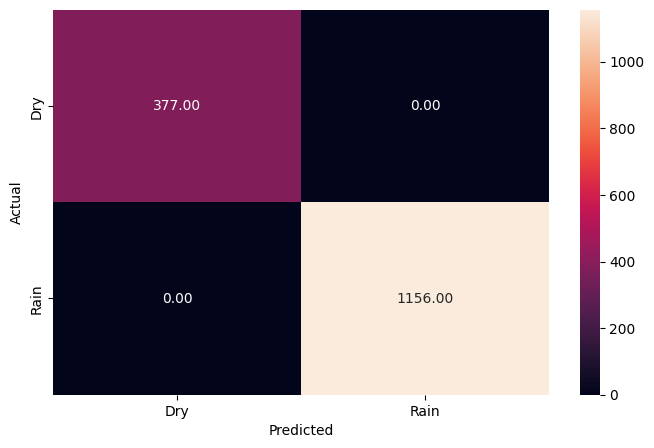

In [411]:
# Checking performance on the train data
y_pred_train_rf_tuned = rf.predict(x_train)

train_rf_acc = metrics_score(y_train, y_pred_train_rf_tuned, target_column)

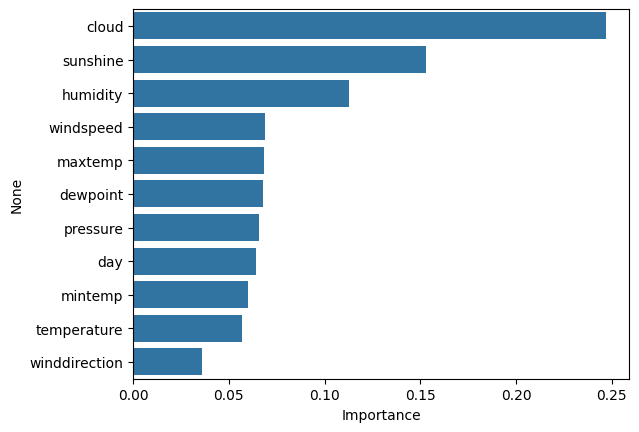

In [412]:
# Plot the feature importance

importances = rf.feature_importances_

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

sns.barplot(x=importance_df.Importance,y=importance_df.index);

In [413]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2190 to 2919
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int64  
 1   pressure       730 non-null    float64
 2   maxtemp        730 non-null    float64
 3   temperature    730 non-null    float64
 4   mintemp        730 non-null    float64
 5   dewpoint       730 non-null    float64
 6   humidity       730 non-null    float64
 7   cloud          730 non-null    float64
 8   sunshine       730 non-null    float64
 9   winddirection  730 non-null    float64
 10  windspeed      730 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 84.6 KB


In [414]:
prediction = pd.DataFrame({ID : test_df.index, RAINFALL: rf.predict(test_df)})
prediction.to_csv('/'.join([path_output,'submission.csv']), index = False)

### **XGBoost**

In [415]:
# Fitting the XGBoost-model
# Method 1) Use Cross-Validation on the dataset to find the best model.
X = final_df[columns]
y = final_df[target_column]

# cross-validator.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

# XGBoost Classifier
xgb_cv = XGBClassifier(
  random_state = 1,
  eval_metric = "logloss", # For multi-class use mlogloss
  tree_method = "hist",
  early_stopping_rounds = 4, # low number to avoid overfitting
)

# Pick the best from the cross validation above
xgb_cv = simple_XGB_optimation(xgb_cv, X, y, cv)

# Method 2) Use the current train/test chunks
xgb_m = XGBClassifier(random_state = 1, eval_metric = "logloss")
xgb_m = xgb_m.fit(x_train, y_train)

[0]	validation_0-logloss:0.46567
[1]	validation_0-logloss:0.42159
[2]	validation_0-logloss:0.40249
[3]	validation_0-logloss:0.38911
[4]	validation_0-logloss:0.38157
[5]	validation_0-logloss:0.38041
[6]	validation_0-logloss:0.37985
[7]	validation_0-logloss:0.38101
[8]	validation_0-logloss:0.38213
[9]	validation_0-logloss:0.38295
Model metrics:
    TRAIN (0.916):    Score = 0.929, Precision = 0.921, Recall = 0.885, Accuracy = 0.929
    TEST  (0.820):    Score = 0.851, Precision = 0.810, Recall = 0.768, Accuracy = 0.851
    
[0]	validation_0-logloss:0.45112
[1]	validation_0-logloss:0.39745
[2]	validation_0-logloss:0.36719
[3]	validation_0-logloss:0.34930
[4]	validation_0-logloss:0.33707
[5]	validation_0-logloss:0.33192
[6]	validation_0-logloss:0.32651
[7]	validation_0-logloss:0.32636
[8]	validation_0-logloss:0.32867
[9]	validation_0-logloss:0.32570
[10]	validation_0-logloss:0.32630
[11]	validation_0-logloss:0.32594
[12]	validation_0-logloss:0.32617
[13]	validation_0-logloss:0.32726
Model 

              precision    recall  f1-score   support

           0   0.725926  0.601227  0.657718       163
           1   0.875479  0.925101  0.899606       494

    accuracy                       0.844749       657
   macro avg   0.800702  0.763164  0.778662       657
weighted avg   0.838375  0.844749  0.839594       657



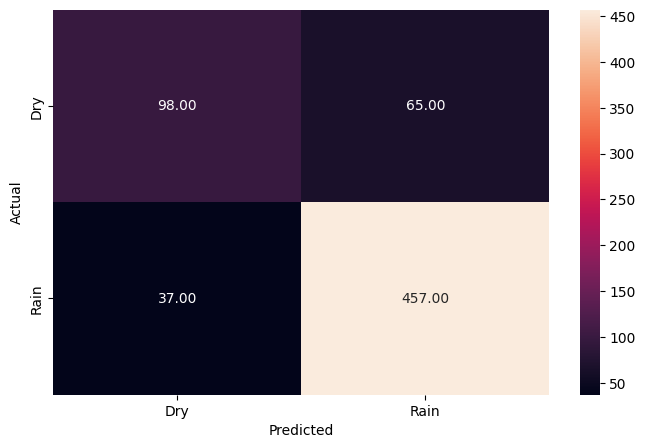

              precision    recall  f1-score   support

           0   0.875912  0.736196  0.800000       163
           1   0.917308  0.965587  0.940828       494

    accuracy                       0.908676       657
   macro avg   0.896610  0.850892  0.870414       657
weighted avg   0.907038  0.908676  0.905889       657



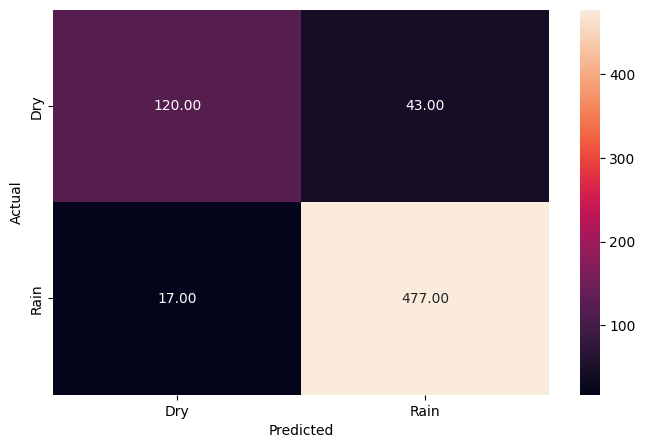

In [416]:
# Checking performance on the test data
y_pred_test_xgb_m = xgb_m.predict(x_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_test)

test_xgbm_acc = metrics_score(y_test, y_pred_test_xgb_m, target_column)
test_xgbcv_acc = metrics_score(y_test, y_pred_test_xgb_cv, target_column)

              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000       377
           1   1.000000  1.000000  1.000000      1156

    accuracy                       1.000000      1533
   macro avg   1.000000  1.000000  1.000000      1533
weighted avg   1.000000  1.000000  1.000000      1533



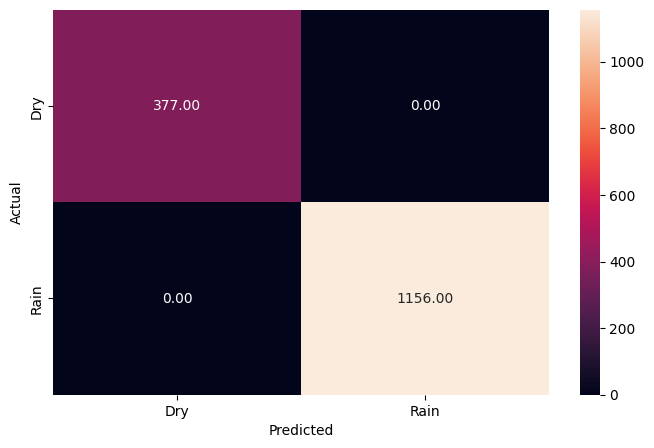

              precision    recall  f1-score   support

           0   0.844380  0.777188  0.809392       377
           1   0.929174  0.953287  0.941076      1156

    accuracy                       0.909980      1533
   macro avg   0.886777  0.865238  0.875234      1533
weighted avg   0.908321  0.909980  0.908692      1533



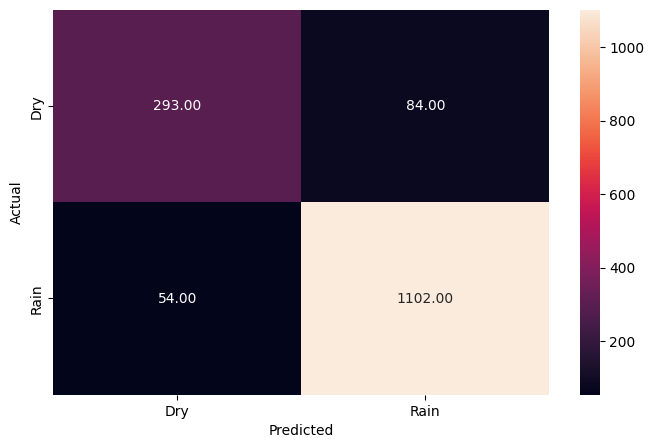

In [417]:
# Checking performance on the train data
y_pred_train_xgb_m = xgb_m.predict(x_train)
y_pred_train_xgb_cv = xgb_cv.predict(x_train)

train_xgbm_acc = metrics_score(y_train, y_pred_train_xgb_m, target_column)
train_xgbcv_acc = metrics_score(y_train, y_pred_train_xgb_cv, target_column)

In [418]:
prediction = pd.DataFrame({ID : test_df.index, RAINFALL: xgb_m.predict(test_df)})
prediction.to_csv('/'.join([path_output,'submission.csv']), index = False)
prediction = pd.DataFrame({ID : test_df.index, RAINFALL: xgb_cv.predict(test_df)})
prediction.to_csv('/'.join([path_output,'submission.csv']), index = False)

In [419]:
pd.DataFrame({
    'Random Forest': [test_rf_acc, train_rf_acc],
    'XGBoost Manual': [test_xgbm_acc, train_xgbm_acc],
    'XGBoost CV': [test_xgbcv_acc, train_xgbcv_acc]
  },
  columns = pd.Index(['Random Forest', 'XGBoost Manual', 'XGBoost CV'], name='Model:'),
  index = pd.Index(['Test Data','Train Data'], name='Data Source'),
).style.format('{:.3f}')

Model:,Random Forest,XGBoost Manual,XGBoost CV
Data Source,,,
Test Data,0.860,0.845,0.909
Train Data,1.000,1.000,0.910
